<a href="https://colab.research.google.com/github/MohamedMousa2000/CNN_For_CIFAR100/blob/main/CIFAR100_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Important libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import albumentations as albu
from skimage.transform import resize
from tensorflow import keras as ks
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from skimage import color
print(tf.__version__)

2.9.2


In [ ]:
#Checking on the GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Connecting to the GPU
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.096166911999944
GPU (s):
0.03779140500000722
GPU speedup over CPU: 81x


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#Defining the variables
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = 'sparse_categorical_crossentropy'
no_classes = 100
no_epochs = 14
optimizer = Adam(lr=0.0001)
validation_split = 0.2
verbosity = 1

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Extracting the data from keras
CIFAR100 = ks.datasets.cifar100
(X_train, Y_train), (X_test, Y_test) = CIFAR100.load_data()

(50000, 32, 32, 3)


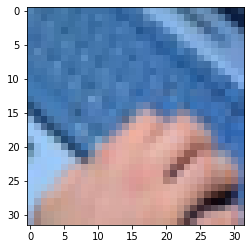

In [ ]:
print(X_train.shape)
plt.imshow(X_train[10])

In [ ]:
def compute_mean_std(cifar100_dataset):
    """compute the mean and std of cifar100 dataset
    Args:
        cifar100_training_dataset or cifar100_test_dataset
        witch derived from class torch.utils.data
    
    Returns:
        a tuple contains mean, std value of entire dataset
    """

    data_r = np.dstack([cifar100_dataset[i][1][:, :, 0] for i in range(len(cifar100_dataset))])
    data_g = np.dstack([cifar100_dataset[i][1][:, :, 1] for i in range(len(cifar100_dataset))])
    data_b = np.dstack([cifar100_dataset[i][1][:, :, 2] for i in range(len(cifar100_dataset))])
    mean   = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std    = np.std(data_r), np.std(data_g), np.std(data_b)

    return mean, std

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

***CNN Structure***

In [ ]:

CNN_Model = ks.models.Sequential()
CNN_Model.add(ks.layers.Conv2D(64,(3,3),activation='relu',input_shape=(32,32,3),data_format="channels_last",padding='same',name='First_Layer_CONV'))

In [ ]:
CNN_Model.add(ks.layers.MaxPool2D((2,2),name='1st_Max_Pooling'))

In [ ]:
CNN_Model.add(ks.layers.Conv2D(128,(3,3),activation='relu',padding='same',name='Third_Layer_CONV'))

In [ ]:
CNN_Model.add(ks.layers.MaxPool2D((2,2),name='2nd_Max_Pooling'))

In [ ]:
CNN_Model.add(ks.layers.Conv2D(256,(3,3),activation='relu',padding='same',name='Fifth_Layer_CONV'))

In [ ]:
CNN_Model.add(ks.layers.MaxPool2D((2,2),name='3rd_Max_Pooling'))

In [ ]:
CNN_Model.add(ks.layers.Flatten(name='FC'))
CNN_Model.add(ks.layers.Dense(512,activation='relu',name='First_Hidden_Layer'))
CNN_Model.add(ks.layers.BatchNormalization())
CNN_Model.add(ks.layers.Dense(256,activation='relu',name='Second_Hidden_Layer'))
CNN_Model.add(ks.layers.Dense(100,activation='softmax',name='Output_Layer'))

In [ ]:
CNN_Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Layer_CONV (Conv2D)   (None, 32, 32, 64)        1792      
                                                                 
 1st_Max_Pooling (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 Third_Layer_CONV (Conv2D)   (None, 16, 16, 128)       73856     
                                                                 
 2nd_Max_Pooling (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 Fifth_Layer_CONV (Conv2D)   (None, 8, 8, 256)         295168    
                                                                 
 3rd_Max_Pooling (MaxPooling  (None, 4, 4, 256)       

In [ ]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


In [ ]:
CNN_Model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
History_Of_Training = CNN_Model.fit(X_train,Y_train,epochs=no_epochs,batch_size=batch_size,verbose=verbosity,validation_split=validation_split,callbacks = [early_stop, rlrop])

Epoch 1/14
800/800 [==============================] - 7s 8ms/step - loss: 3.4752 - accuracy: 0.1758 - val_loss: 3.6247 - val_accuracy: 0.1791 - lr: 0.0010
Epoch 2/14
800/800 [==============================] - 6s 7ms/step - loss: 2.6794 - accuracy: 0.3179 - val_loss: 3.0321 - val_accuracy: 0.2671 - lr: 0.0010
Epoch 3/14
800/800 [==============================] - 5s 7ms/step - loss: 2.2921 - accuracy: 0.3979 - val_loss: 2.5697 - val_accuracy: 0.3439 - lr: 0.0010
Epoch 4/14
800/800 [==============================] - 5s 7ms/step - loss: 2.0290 - accuracy: 0.4587 - val_loss: 2.7120 - val_accuracy: 0.3423 - lr: 0.0010
Epoch 5/14
800/800 [==============================] - 5s 7ms/step - loss: 1.7986 - accuracy: 0.5091 - val_loss: 2.5814 - val_accuracy: 0.3709 - lr: 0.0010
Epoch 6/14
800/800 [==============================] - 5s 7ms/step - loss: 1.5899 - accuracy: 0.5606 - val_loss: 2.4098 - val_accuracy: 0.4092 - lr: 0.0010
Epoch 7/14
800/800 [==============================] - 6s 7ms/step - lo

In [ ]:
Training_Loss, Training_Accuracy = CNN_Model.evaluate(X_train,Y_train)
print(f"Accuracy = {round(float(Training_Accuracy),2)}")

1563/1563 [==============================] - 6s 3ms/step - loss: 0.8093 - accuracy: 0.8533
Accuracy = 0.85


In [ ]:
Test_Loss, Test_Accuracy = CNN_Model.evaluate(X_test,Y_test)
print(f"Accuracy = {round(float(Test_Accuracy),2)}")

313/313 [==============================] - 1s 3ms/step - loss: 3.4162 - accuracy: 0.4357
Accuracy = 0.44


Test loss: 3.416168689727783 / Test accuracy: 0.435699999332428


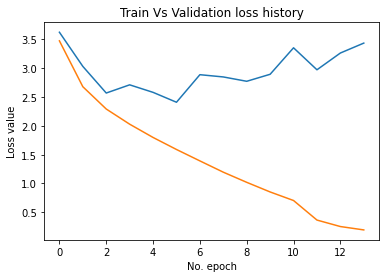

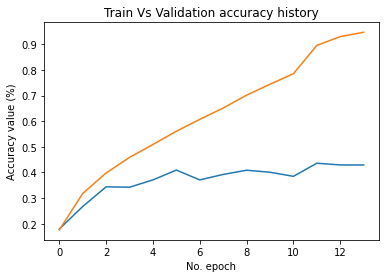

In [ ]:
score = CNN_Model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualize history
# Plot history: Loss
plt.plot(History_Of_Training.history['val_loss'])
plt.plot(History_Of_Training.history['loss'])
plt.title('Train Vs Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(History_Of_Training.history['val_accuracy'])
plt.plot(History_Of_Training.history['accuracy'])
plt.title('Train Vs Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
Predictions = CNN_Model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [ ]:
Predictions = np.argmax(Predictions, axis=1)

In [ ]:
print("Classification Report:")
print(classification_report(Predictions, Y_test))
print("------------------------------------------------------")
print("Confussion Matrix:")
print(confusion_matrix(Predictions, Y_test))
print("------------------------------------------------------")
print("Accuracy:", accuracy_score(Predictions, Y_test)*100, "%")

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.55      0.66       147
           1       0.36      0.68      0.47        53
           2       0.28      0.23      0.25       124
           3       0.22      0.21      0.21       106
           4       0.28      0.30      0.29        94
           5       0.37      0.42      0.39        88
           6       0.58      0.48      0.52       121
           7       0.35      0.59      0.44        59
           8       0.49      0.70      0.58        70
           9       0.62      0.43      0.51       145
          10       0.33      0.29      0.31       112
          11       0.26      0.24      0.25       107
          12       0.36      0.50      0.42        72
          13       0.46      0.44      0.45       105
          14       0.24      0.48      0.32        50
          15       0.47      0.31      0.37       152
          16       0.44      0.45      0.44        98
    

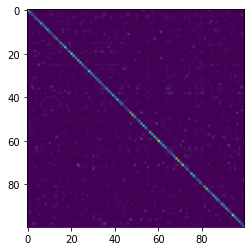

In [ ]:
plt.imshow(confusion_matrix(Predictions, Y_test))